# INTRODUCCIÓN

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, se puede saber rápidamente el valor de mercado de tu coche. Se tiene acceso al historial: especificaciones técnicas, versiones de equipamiento y precios.

Se va a crear un modelo que determine el valor del mercado de los mismos
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [32]:
#Librerías Necesarias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
#Importando y checando información del DataFrame y su estadística descriptiva
df = pd.read_csv("dataset/car_data.csv")

print(df.info())
print()
print('Estadística descriptiva de DataFrame:')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

De lo explorado anteriormente, se tiene lo siguiente:
- Columnas con letras Mayus/Minus mezcladas. Hay que separar entre palabras con guión bajo.

- Cambiar tipo de datos que sean necesario.

- Columna NumberOfPictures al poseer valores cero (min=0, max=0), puede ser eliminada.

Además:

- Price tiene valores de 0 a 20000.
- Power tiene valores de 0 a 20000.
- RegistrationYear tiene valores de 0 a 9999.
- RegistrationMonth tiene valores de 0 a 12. Siendo que sólo son 12 meses lo que tiene un año. Estos vaalores se tratarán algunas celdas más abajo.

In [4]:
#Cambiando formato de columnas para una mejor exploración de datos
df.columns = df.columns.str.replace(r'([A-Z])', r'_\1', regex=True).str.strip('_').str.lower()
print(df.columns)#mostrando cambios

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [5]:
#Cambiando tipo de datos
date_col = df[['date_crawled', 'date_created', 'last_seen']]
category_col = df[['vehicle_type', 'fuel_type', 'gearbox']]
for col in date_col:
    df[col] = pd.to_datetime(df[col], format= '%d/%m/%Y %H:%M')
    
for col in category_col:
    df[col] = df[col].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  category      
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  category      
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  category      
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [6]:
#Eliminando columnas no necesarias
df_new = df.drop(['number_of_pictures','date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)
print(df_new.columns)#observando cambios

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired'],
      dtype='object')


Las columnas date_crawled, date_created, last_seen y postal_code tambien se han eliminado debido a que las mismas son fechas que no tienen relación alguna con el objetivo solicitado, esto es, el precio.

In [7]:
#Checando existencia de valores ausentes y duplicados
print(df_new.isna().sum())
print()
print('Valores duplicado:', df_new.duplicated().sum())

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
dtype: int64

Valores duplicado: 27543


Más adelante se verá si se rellenan los valores ausentes con la moda (para categóricos) y la mediana (para númericos) o si se eliminaran los mismos.

In [8]:
#Tratando valores duplicados
#Chequeamos la duplicidad de los mismos para saber si eliminarlos o no
dup_row = df_new[df_new.duplicated(keep=False)]
#keep=False asegura que todas las instancias duplicadas se marquen, no solo las adicionales.

print(f'Total de registros duplicados: {len(dup_row)}')

dup_row_sorted = dup_row.sort_values(list(df_new.columns))
#Muestro filas duplicadas
print(dup_row_sorted)

Total de registros duplicados: 49086
        price vehicle_type  registration_year gearbox  power        model  \
199835      0          bus               1994  manual      0  transporter   
283241      0          bus               1994  manual      0  transporter   
82258       0          bus               1994  manual     68  transporter   
254668      0          bus               1994  manual     68  transporter   
107497      0          bus               1995  manual    102  transporter   
...       ...          ...                ...     ...    ...          ...   
320429  20000        sedan               2011    auto    265     c_klasse   
320559  20000        sedan               2011    auto    265     c_klasse   
321365  20000        sedan               2011    auto    265     c_klasse   
142818  20000          suv               2011  manual    150       tiguan   
143161  20000          suv               2011  manual    150       tiguan   

        mileage  registration_month fu

Debido a lo mostrado anteriormente, se ha decidido eliminar los duplicados del DataFrame, pues en un pequeño análisis se pudo observar los duplicados explicitos de este. El mismo repetía datos ya existentes.

In [9]:
#Eliminando duplicados
df_new.drop_duplicates(inplace= True)
#Muestro la existencia de los cambios
print(f'Valores duplicados: {df_new.duplicated().sum()}')

Valores duplicados: 0


Antes de tratar los valores ausentes se trabajaran datos de dudosa información (atípicos) teniendo en cuenta los objetivos de Rusty Bargain. Tales datos se pueden observar en la columna 'registration_year', 'power' y 'registration_month'

### Valores Atípicos

In [10]:
#Observando mínimos y máximos en columna con datos sospechosamente errados
columns = [
    ('registration_year', 'Año'),
    ('power', 'Potencia'),
    ('registration_month', 'Mes')
]

for col, description in columns:
    print(f'{description} más bajo registrado: {df_new[col].min()}')
    print(f'{description} más alto registrado: {df_new[col].max()}')

Año más bajo registrado: 1000
Año más alto registrado: 9999
Potencia más bajo registrado: 0
Potencia más alto registrado: 20000
Mes más bajo registrado: 0
Mes más alto registrado: 12


- El año más bajo registrado para un automovil en el Dataset es 1000 y el más alto es 9999. Teniendo en cuenta que nos encontramos en el año 2024 y, además, la invención del automovil se remonta a 1886 con el primer vehiculo de tres ruedas impulsado por gasolina, se pueden filtrar tales valores acotandolos entre tales fechas.
Por cuestiones de comodidad y considerando que el auge de las marcas inicia a partir de 1900, el rango a usar en el filtrado de tales datos será (1900, 2024).

- Se tiene además que la potencia mínima de vehiculos registrados en Dataset es de 0. Obviamente, un coche con potencia cero implica un coche, o sin motor o un no-coche(siendo que el mínimo para un auto es de 60CV). Mientras que para la potencia máxima se tiene 20000 CV, como actualmente en el mercado el automovil con mayor potencia es el Lotus Evija (contando con una potencia de 2039CV), esto podría tratarse de un simple error de tipeo. Se verá a continuación.

- Para el mes de registro, se tiene un mínimo de 0 y máximo de 12. El mínimo podría indicar que, quizás, el vendedor olvidó proveer tal información a Rusty.

Los datos anteriores se tratarán, ya sea eliminando lo necesario o rellenando datos con lo debido, antes de proceder con los valores ausentes existentes en el Dataset.

In [11]:
#Filtrando y acotando datos para columna del año de registro (registration_year)
df_new_filt = df_new.query('1900 <= registration_year <= 2024')
print(df_new_filt['registration_year'].describe())#compruebo cambios

count    326663.000000
mean       2003.059955
std           7.600719
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


In [12]:
#filtrando precio para valores mayores o iguales a 100 (price)
df_new_filt = df_new_filt.query('price >= 100')
print(df_new_filt['price'].describe())#compruebo

count    314923.00000
mean       4568.73873
std        4519.52608
min         100.00000
25%        1200.00000
50%        2899.00000
75%        6500.00000
max       20000.00000
Name: price, dtype: float64


Se ha decidido filtrar de la anterior forma debido a que se construirá un modelo que prediga tales valores (los ceros), además de que, sea dicho de paso, precios por debajo de 100 euros son casos en extremo específicos, como promociones, precio simbólico de venta, subasta, etc.

In [13]:
#Limitando valores en la columna de potencia  y sustituyendo valores atípicos con valores NaN(power)
df_new_filt = df_new_filt.query('power <= 2000')
#reemplazo
df_new_filt.loc[df_new_filt['power'] < 45, 'power'] = np.nan
print(df_new_filt['power'].describe())#compruebo

count    279720.000000
mean        121.842260
std          63.716551
min          45.000000
25%          78.000000
50%         111.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64


En la celda anterior se filtró la potencia para valores menores o iguales a 2000. Se conservan todos los valores por debajo de este (incluyendo los de potencia 0) para luego tratar el mínimo arrojado por el Dataset (valor extraño/atípico) como un valor ausente, y luego, en el apartado donde se tratarán los valores ausentes, se procederá a rellenar o elimminar tales datos, dependiendo del análisis y a la conclusión a la que se llegue para crear un modelo robusto.

Se ha decidido hacer para valores menores a 45 debido a que en el mercado, desde el año 1960 con la producción del Peel P50, la gran mayoría de los coches comerciales chicos, cuya caracteristica más notable es su baja potencia, van por encima de los 45CV.

In [14]:
#Tratando valores atípicos. Mes 0 (registration_month)
#Reemplanzando con la mediana
df_new_filt.loc[df_new_filt['registration_month'] == 0, 'registration_month'] = df_new_filt['registration_month'].median()
df_new_filt['registration_month'] = df_new_filt['registration_month'].astype('int')
print(df_new_filt['registration_month'].value_counts(normalize=True).sort_index())#compruebo valores únicos

registration_month
1     0.066093
2     0.060785
3     0.098572
4     0.084428
5     0.083176
6     0.184823
7     0.078240
8     0.064362
9     0.067939
10    0.074269
11    0.068390
12    0.068923
Name: proportion, dtype: float64


### Valores Ausentes

Tratando los valores ausentes en: vehicle_type, gearbox, fuel_type, model, not_repaired y power.

In [15]:
#Observo el DF actualizado respecto a los valores ausentes
print(df_new_filt.isna().sum())

price                     0
vehicle_type          31018
registration_year         0
gearbox               14652
power                 35094
model                 16282
mileage                   0
registration_month        0
fuel_type             27204
brand                     0
not_repaired          60412
dtype: int64


Se intentarán rellenar tales valores ausentes creando funciones que se implementarán en cada columna para lograr esto, a su vez, se tratarán aquellos que no pudieron haber sido rellenados eliminando los mismos.

In [16]:
#Función moda para usar en columnas de datos categóricos faltantes
def mode_f(var):#creo una función para la moda
    return var.mode().iloc[0] if len(var) > 0 else np.nan

#### vehicle_type

Los tipos de vehiculos están relacionados respecto a la marca y al modelo del coche, por lo que se procederá a usar tales categorías para rellenar los valores ausentes con la moda.

In [17]:
vehicle_values = df_new_filt.dropna(subset=['vehicle_type', 'model'])

vehicle_model = vehicle_values.groupby(['brand','model'])['vehicle_type'].agg(mode_f).reset_index()
vehicle_model_dict = vehicle_model.set_index(['brand', 'model'])['vehicle_type'].to_dict()

def filling_v(row):
    model = row['model']
    vehicle = row['vehicle_type']
    brand = row['brand']

    if pd.isna(vehicle):
        return vehicle_model_dict.get((brand, model), np.nan)
    return vehicle

#aplico función al Dataset y almaceno en columna
df_new_filt['vehicle_type'] = df_new_filt.apply(filling_v, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_v = df_new_filt[df_new_filt['vehicle_type'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_v)}')

Cantidad de valores ausentes luego de aplicar función: 4963


In [18]:
#elimino los que no pudieron ser rellenados
df_new_filt = df_new_filt.dropna(subset=['vehicle_type'])
no_nan_v = df_new_filt[df_new_filt['vehicle_type'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_v)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### gearbox

Como el tipo de caja está relacionada con respecto al modelo y la marca del vehiculo, se intentarán rellenar los valores ausentes con la moda de las mismas por ser variables categóricas.

In [20]:
#Filtrando columnas
gearbox_values = df_new_filt.dropna(subset=['gearbox', 'model'])

gearbox_model = gearbox_values.groupby(['brand', 'model'])['gearbox'].agg(mode_f).reset_index()
gearbox_model_dict = gearbox_model.set_index(['brand', 'model'])['gearbox'].to_dict()

def filling_g(row):#creo función que llenará la columna con los valores faltantantes
    model = row['model']
    gearbox = row['gearbox']
    brand = row['brand']

    if pd.isna(gearbox):
        return gearbox_model_dict.get((brand, model), np.nan)
    return gearbox

#aplico función a Dataset y guardo en columna del mismo
df_new_filt['gearbox'] = df_new_filt.apply(filling_g, axis=1)

#Comprobando si existen valores sin rellenar
no_value_g = df_new_filt[df_new_filt['gearbox'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_g)}')

Cantidad de valores ausentes luego de aplicar función: 875


In [21]:
df_new_filt = df_new_filt.dropna(subset=['gearbox'])
no_nan_g = df_new_filt[df_new_filt['gearbox'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_g)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### fuel_type

Como petrol = gasoline, primero se procederá a hacer tal reemplazo antes de proceder a filtrar los valores respecto al modelo del vehiculo, el cual está relacionado con el tipo de combustible que estos usan.

In [22]:
#Reemplazo
df_new_filt['fuel_type'] = df_new_filt['fuel_type'].replace('petrol', 'gasoline')

#Filtro
fuel_values = df_new_filt.dropna(subset=['fuel_type', 'model'])

fuel_model = fuel_values.groupby(['model'])['fuel_type'].agg(mode_f).reset_index()
fuel_model_dict = fuel_model.set_index(['model'])['fuel_type'].to_dict()

def filling_f(row):#creo función
    model = row['model']
    fuel = row['fuel_type']
    
    if pd.isna(fuel):
        return fuel_model_dict.get(model, np.nan)
    return fuel

#aplico función al Dataset y almaceno en columna
df_new_filt['fuel_type'] = df_new_filt.apply(filling_f, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_f = df_new_filt[df_new_filt['fuel_type'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_f)}')

/tmp/ipykernel_47168/773678940.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_new_filt['fuel_type'] = df_new_filt['fuel_type'].replace('petrol', 'gasoline')


Cantidad de valores ausentes luego de aplicar función: 2021


In [23]:
df_new_filt = df_new_filt.dropna(subset=['fuel_type'])
no_nan_f = df_new_filt[df_new_filt['fuel_type'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_f)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### model

Los modelos tienen una relación directa con la marca del coche y el año en que fueron puestos al mercado.

In [24]:
model_values = df_new_filt.dropna(subset=['model'])

model_brand = model_values.groupby(['brand','registration_year'])['model'].agg(mode_f).reset_index()
model_brand_dict = model_brand.set_index(['brand', 'registration_year'])['model'].to_dict()

def filling_m(row):
    model = row['model']
    year = row['registration_year']
    brand = row['brand']

    if pd.isna(model):
        return model_brand_dict.get((brand, model), np.nan)
    return model

#aplico función al Dataset y almaceno en columna
df_new_filt['model'] = df_new_filt.apply(filling_m, axis=1)

#Compruebo existencia de valores ausentes luego de la función
no_value_m = df_new_filt[df_new_filt['model'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_m)}')

Cantidad de valores ausentes luego de aplicar función: 8423


In [25]:
df_new_filt = df_new_filt.dropna(subset=['model'])
no_nan_m = df_new_filt[df_new_filt['model'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_m)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### power

Ahora se intentarán rellenar los valores ausentes en este columna en función del modelo del coche, ya que la potencia está relacionado con el mismo.

In [26]:
#filtrando
df_new_filt['power'] = pd.to_numeric(df_new_filt['power'], errors='coerce')#cambio tipo de dato a númerico
power_values = df_new_filt.dropna(subset=['power'])

power_model = power_values.groupby(['model'])['power'].median().reset_index()
power_model_dict = power_model.set_index(['model'])['power'].to_dict()

def filling_p(row):
    model = row['model']
    power = row['power']

    if pd.isna(power):
        return model_brand_dict.get(model, np.nan)
    return power

#Aplico y almaceno
df_new_filt['power'] = df_new_filt.apply(filling_p, axis=1)

#compruebo existencia de ausentes luego de aplicada la función
no_value_p = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de aplicar función: {len(no_value_p)}')

Cantidad de valores ausentes luego de aplicar función: 30332


In [27]:
df_new_filt = df_new_filt.dropna(subset=['power'])
no_nan_p = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_p)}')

Cantidad de valores ausentes luego de eliminar filas: 0


#### not_repaired

Como not_repaired depende de quien vende el autommovil, de si tal información fue proporcionada o no, se ha tomado la decisión de eliminar tales valores ausentes

In [28]:
#Observó cantidad de valores ausentes
print(df_new_filt.isna().sum())
#elimino
df_new_filt = df_new_filt.dropna(subset=['not_repaired'])
no_nan_not_r = df_new_filt[df_new_filt['power'].isna()]
print(f'Cantidad de valores ausentes luego de eliminar filas: {len(no_nan_not_r)}')

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
mileage                   0
registration_month        0
fuel_type                 0
brand                     0
not_repaired          39632
dtype: int64
Cantidad de valores ausentes luego de eliminar filas: 0


In [29]:
#Nuevo DataFrame
df_new_filt.reset_index(drop=True, inplace=True)
print(df_new_filt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228568 entries, 0 to 228567
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               228568 non-null  int64  
 1   vehicle_type        228568 non-null  object 
 2   registration_year   228568 non-null  int64  
 3   gearbox             228568 non-null  object 
 4   power               228568 non-null  float64
 5   model               228568 non-null  object 
 6   mileage             228568 non-null  int64  
 7   registration_month  228568 non-null  int64  
 8   fuel_type           228568 non-null  object 
 9   brand               228568 non-null  object 
 10  not_repaired        228568 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 19.2+ MB
None


In [31]:
#Observo correlación
numeric_df = df_new_filt.select_dtypes(include=[float, int])
print(numeric_df.corr())

                       price  registration_year     power   mileage  \
price               1.000000           0.485073  0.435873 -0.400043   
registration_year   0.485073           1.000000  0.080923 -0.334778   
power               0.435873           0.080923  1.000000  0.101538   
mileage            -0.400043          -0.334778  0.101538  1.000000   
registration_month  0.011892          -0.002466  0.017384  0.006372   

                    registration_month  
price                         0.011892  
registration_year            -0.002466  
power                         0.017384  
mileage                       0.006372  
registration_month            1.000000  


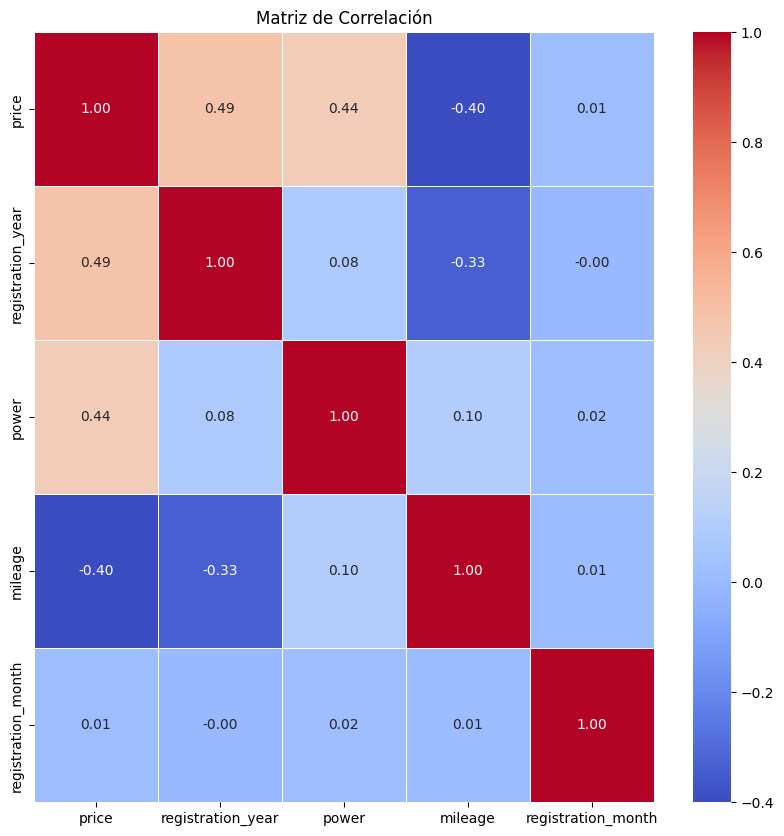

In [33]:
#Graficamos
correlation_matrix = numeric_df.corr()

# Configuramos el tamaño de la figura
plt.figure(figsize=(10, 10))

#heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Matriz de Correlación")
plt.show()

De la correlación se ha obtenido lo siguiente:
- Precio (price): 
    - respecto a año de registo (registration_year): correlación positiva, es decir, mientras más nuevo el vehiculo que ha sido registrado, más alto será su precio.
    - respecto a potencia (power): positiva. Coche con mayor potencia tiende a ser más costoso.
    - respecto a kilometraje (mileage): correlación negativa. Mientras más recorrido tenga el auto más económico será el mismo.

- Año de registro (registration_year):
    - respecto a potencia (power): Correlación muy débil. Indica que no hay relación respecto a esta característica.
    - respecto a kilometraje (mileage): negativa. Sugiere que los vehiculos más antiguos RESPECTO AL AÑO DE REGISTRO MENOS RECIENTE tiende a tener mayor kilometraje.

## Entrenamiento del Modelo 

Antes de pasar a entrenar el modelo, primero crearemos una nueva característica en el Dataset ya filtrado. Esta característica tendrá como finalidad almacenar la antigüedad de cada vehiculo.

In [34]:
actual_year = 2024
df_new_filt['vehicle_age'] = actual_year - df_new_filt['registration_year']
df_new_filt.rename(columns={'registration_year' : 'vehicle_age'})
print(df_new_filt)
print()
print(df_new_filt['vehicle_age'].describe())

        price vehicle_type  registration_year gearbox  power        model  \
0        1500        small               2001  manual   75.0         golf   
1        3600        small               2008  manual   69.0        fabia   
2         650        sedan               1995  manual  102.0          3er   
3        2200  convertible               2004  manual  109.0      2_reihe   
4        2000        sedan               2004  manual  105.0      3_reihe   
...       ...          ...                ...     ...    ...          ...   
228563   7900        sedan               2010  manual  140.0         golf   
228564   5250        wagon               2016    auto  150.0          159   
228565   3200        sedan               2004  manual  225.0         leon   
228566   1199  convertible               2000    auto  101.0       fortwo   
228567   9200          bus               1996  manual  102.0  transporter   

        mileage  registration_month fuel_type       brand not_repaired  \
0

In [35]:
#Último ajuste
df_new_filt = df_new_filt.drop(['registration_month'], axis=1)
#observo cambios
print(df_new_filt.columns)

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired',
       'vehicle_age'],
      dtype='object')


In [36]:
#Codificación y Escalado
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'not_repaired']
numerical_cols = ['power', 'mileage', 'vehicle_age']

#Asigno a variable que luego será usada
df_new_filt_OHE = df_new_filt.copy()

#Codifico frecuencia para columnas categóricas
#Asigno proporción de su aparición en las respectivas columnas
for col in categorical_cols:
    encod_frequency = df_new_filt_OHE[col].value_counts() / len(df_new_filt_OHE)
    df_new_filt_OHE[col] = df_new_filt_OHE[col].map(encod_frequency)

#Escalo características númericas
scaler = StandardScaler()
df_new_filt_OHE[numerical_cols] = scaler.fit_transform(df_new_filt_OHE[numerical_cols])

#Observo
print('Luego de codificado de frecuencia y escalado:')
print(df_new_filt_OHE.head())

Luego de codificado de frecuencia y escalado:
   price  vehicle_type  registration_year   gearbox     power     model  \
0   1500      0.236862               2001  0.794998 -0.788873  0.084693   
1   3600      0.236862               2008  0.794998 -0.887403  0.006956   
2    650      0.300305               1995  0.794998 -0.345488  0.060144   
3   2200      0.064939               2004  0.794998 -0.230537  0.015540   
4   2000      0.300305               2004  0.794998 -0.296223  0.010798   

    mileage  fuel_type     brand  not_repaired  vehicle_age  
0  0.611530   0.981787  0.212256      0.885474     0.394724  
1 -1.015947   0.981787  0.018025      0.885474    -0.696362  
2  0.611530   0.981787  0.109591      0.114526     1.329940  
3  0.611530   0.981787  0.031505      0.885474    -0.072884  
4  0.611530   0.981787  0.016446      0.885474    -0.072884  


In [37]:
#Características y Objetivo
#Dividiendo el Dataset y verificando conjunto
X = df_new_filt_OHE.drop('price', axis=1)
y = df_new_filt_OHE['price']

#entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

#verificando forma
print(X_train.shape, X_test.shape)

(171426, 10) (57142, 10)


### Regresión Lineal

In [38]:
lr_model = LinearRegression()
%time lr_model.fit(X_train, y_train)#comando para medir tiempo de ejecución en toda la celda
%time lr_predict = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_predict)**0.5
print(f'RMSE de Regresión Lineal: {lr_rmse}')

CPU times: user 138 ms, sys: 87.7 ms, total: 226 ms
Wall time: 154 ms
CPU times: user 29.4 ms, sys: 0 ns, total: 29.4 ms
Wall time: 6.57 ms
RMSE de Regresión Lineal: 3151.9769492467467


La regresión lineal ha devuelto un RMSE de 3152, siendo está la prueba de cordura y sierviendo como valor base para comparar los otros modelos y métodos de potenciación de gradiente. Necesitamos menos que lo arrojado en esta prueba de cordura.

### Árbol de Decisión

Se empleará librería GridsearchCV para obtener lo mejores hiperparametros, luego se entrenará el modelo para finalizar con la medición del tiempo de entrenamiento y prueba según las instrucciones indicadas en el proyecto.

In [39]:
#hiperparámetros de árbol de decisión
dt_params = {
    'max_depth': [1, 2, 3, 4, 5, 6] ,
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
}

#GridSearchCV e hiperparámetros establecidos.
#Metríca y valor para validación cruzada
dt_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=dt_params,
    scoring='neg_root_mean_squared_error',
    cv=3)

In [40]:
#entrenamos para encontrar mejores hiperparametros
dt_grid.fit(X_train, y_train)
#Buscamos mejores hiperparametros que devuelven más bajo RSME
max_score = dt_grid.cv_results_['mean_test_score'].max()
index_max_score = np.where(dt_grid.cv_results_['mean_test_score'] == max_score)[0][0]

best_set_of_params = dt_grid.cv_results_['params'][index_max_score]
print(f'Hiperparámetros recomendados: {best_set_of_params} | Mejor RSME: {-max_score}')

Hiperparámetros recomendados: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4} | Mejor RSME: 2341.2328590341663


In [41]:
#Entrenamiento de modelo
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=6, min_samples_split=2, min_samples_leaf=2)
%time dt_model.fit(X_train, y_train)
%time dt_predict = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_predict)**0.5
print(f'RMSE de Árbol de Decisión: {dt_rmse}')

CPU times: user 429 ms, sys: 0 ns, total: 429 ms
Wall time: 426 ms
CPU times: user 9.27 ms, sys: 0 ns, total: 9.27 ms
Wall time: 9.17 ms
RMSE de Árbol de Decisión: 2327.674577983882


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME más inferior (2328.080) respecto a la prueba de cordura (regresión lineal=3152), indicando que nos encontramos en buen camino para hallar el mejor modelo.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 307 ms, 
    - sys: 0 ns, 
    - total: 307 ms
    - Wall time: 305 ms
- Predicción:
    - CPU times: user 7.42 ms
    - sys: 0 ns
    - total: 7.42 ms 
    - Wall time: 7.11 ms

### Bosque Aleatorio

Al igual que 'árbol de decisión', se empleará librería GridsearchCV para obtener lo mejores hiperparametros y luego entrenar nuestro modelo.

In [42]:
rf_params = {
    'n_estimators' : [10, 20, 40],
    'max_depth': [1, 2, 3, 4, 5, 6] 
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=3)

In [43]:
#entrenamos para encontrar mejores hiperparametros
rf_grid.fit(X_train, y_train)
#Buscamos mejores hiperparametros que devuelven más bajo RSME
max_score = rf_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(rf_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = rf_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_set_of_params} | Mejor RSME: {-max_score}')

/home/nick/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Hiperparámetros recomendados: {'max_depth': 6, 'n_estimators': 40} | Mejor RSME: 2250.5542954273533


In [44]:
#Entrenamiento de modelo
rf_model = RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=20)
%time rf_model.fit(X_train, y_train)
%time rf_predict = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predict)**0.5
print(f'RMSE de Bosque Aleatorio: {rf_rmse}')

CPU times: user 5.33 s, sys: 11.9 ms, total: 5.34 s
Wall time: 5.34 s
CPU times: user 72.5 ms, sys: 0 ns, total: 72.5 ms
Wall time: 72.5 ms
RMSE de Bosque Aleatorio: 2260.709981153769


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME un poco más inferior (2259.878) al modelo anterior (2328.080), cumpliendo así con la mejora del mismo. Cabe acotar que, a dicho resultado se ha de considerar el tiempo de entrenamiento para nuestro modelo, pues el mismo resulto ser mucho más alto que el anterior, por lo que podría inferirse que, dada la mejora teniendo en cuenta el tiempo de entrenamiento del modelo, el mismo no resulta ser demasiado eficiente  considerando esto por su infima mejora del RSME que presenta respecto al Árbol de Regresión.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 4.39 s
    - sys: 3.34 ms, 
    - total: 4.39 s 
    - Wall time: 4.39 s
- Predicción:
    - CPU times: user 78.1 ms
    - sys: 0 ns
    - total: 78.1 ms
    - Wall time: 77.8 ms

### Catboost

Empleando el método de potenciación de gradiente CatBoost para mejorar el modelo de aprendizaje. Este algoritmo no requiere que se preprocesen las características categóricas, por lo que no es necesario usar la variable que almacena el DataFrame encodificado OHE.

In [45]:
#Características y objetivos antes de OHE
features = df_new_filt.drop('price', axis=1)
target = df_new_filt['price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

#Selecciono sólo las columnas cuyas características son categóricas
categorical_columns = features_train.select_dtypes(include=['object']).columns.tolist()

#Tipo 'category'
for column in categorical_columns:
    features_train.loc[:, column] = features_train.loc[:, column].astype('category')
    features_test.loc[:, column] = features_test.loc[:, column].astype('category')

#Hiperparámetros a ajustar
cb_params = {
    'depth': [4, 6, 10],
    'learning_rate': [0.1, 0.2, 0.5]
}

#Estimador
cb_est = CatBoostRegressor(iterations=100, cat_features=categorical_columns, verbose=False, loss_function='RMSE')

cb_grid = GridSearchCV(
    estimator=cb_est,
    param_grid=cb_params,
    scoring='neg_root_mean_squared_error',
    cv=3
)

In [46]:
cb_grid.fit(features_train, target_train)

max_score = cb_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(cb_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = cb_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}')

Hiperparámetros recomendados: {'depth': 10, 'learning_rate': 0.5} | Mejor RSME: 1626.5324008123105


In [47]:
cb_model = CatBoostRegressor(random_state=12345, iterations=100, depth=10, learning_rate=0.5, loss_function='RMSE', cat_features=categorical_columns, verbose=False)
%time cb_model.fit(features_train, target_train)
%time cb_predict = cb_model.predict(features_test)
cb_rmse = mean_squared_error(target_test, cb_predict)**0.5
print(f'RMSE de CatBoost: {cb_rmse}')

CPU times: user 21.6 s, sys: 2.07 s, total: 23.7 s
Wall time: 4.48 s
CPU times: user 87.5 ms, sys: 36.6 ms, total: 124 ms
Wall time: 70.9 ms
RMSE de CatBoost: 1615.3803898078384


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME de enorme mejora (1615.380), cumpliendo además con un tiempo de entrenamiento bastante optimo, por lo que, hasta ahora, el modelo de entrenamiento basado en catboost viene siendo el más prometedor, tanto en velocidad como en eficiencia en las predicciones.

Se tiene los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 21.7 s
    - sys:  47.4 ms, 
    - total: 21.7 s 
    - Wall time: 21.8 s
- Predicción:
    - CPU times: 85.6 ms 
    - sys: 0 ns
    - total: 85.6 ms
    - Wall time: 85.5 ms

### XGBoost

A diferencia de CatBoost, XGBoost requiere previamente un encodificado de características, por lo que tomaremos el conjunto perteneciente a tal encodificado OHE 
ya que sólo acepta características númericas.

In [48]:
#Hiperparametros
xgb_params = {'max_depth': [4, 6, 8], 
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.6, 0.8]
}

xgb_est = XGBRegressor()

xgb_grid = GridSearchCV(estimator=xgb_est, param_grid=xgb_params, scoring='neg_root_mean_squared_error', cv=3)

In [49]:
"""#Buscamos los mejores hiperparametros
xgb_grid.fit(X_train, y_train)
max_score = xgb_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(xgb_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = xgb_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}')"""

'#Buscamos los mejores hiperparametros\nxgb_grid.fit(X_train, y_train)\nmax_score = xgb_grid.cv_results_["mean_test_score"].max()\nindex_max_score = np.where(xgb_grid.cv_results_["mean_test_score"] == max_score)[0][0]\n\nbest_params = xgb_grid.cv_results_["params"][index_max_score]\n\nprint(f\'Hiperparámetros recomendados: {best_params} | Mejor RSME: {-max_score}\')'

**NOTA**: El código anterior se ha dejado comentado debido al tiempo requerido de cálculo para hallar los hiperparmaetros más óptimos.

In [50]:
#Entrenamos modelo con hiperparametros
xgb_model = XGBRegressor(random_state=12345, max_depth=8, n_estimators=100, learning_rate=0.1, subsample=0.8)
%time xgb_model.fit(X_train, y_train)
%time xgb_predict = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_predict)**0.5
print(f'RMSE de XGBoost: {xgb_rmse}')

CPU times: user 13 s, sys: 68 ms, total: 13.1 s
Wall time: 1.74 s
CPU times: user 449 ms, sys: 9.66 ms, total: 458 ms
Wall time: 59.6 ms
RMSE de XGBoost: 1619.0696850018041


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME bastante aceptable (1619) respecto a la prueba de cordura (3155.442) pero no con una mejora respecto a catboost(1615).

Se obtuvo los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 39.4 s
    - sys: 123 ms
    - total: 39.5 s
    - Wall time: 39.8 s
- Predicción:
    - CPU times: user 429 ms
    - sys: 0 ns
    - total: 429 ms
    - Wall time: 418 ms

### LightGBM

Al igual que CatBoost, puede emplearse sin el preprocesamiento de las características categóricas encodificadas con OHE. Además, es necesario que se transformen previamente las características a tipo int o category.

In [51]:
#Igual que catboost, tomo el conjunto para antes de OHE
for col in categorical_columns:
    df_new_filt[col] = df_new_filt[col].astype('category')

X_LGBM = df_new_filt.drop('price', axis=1)
y_LGBM = df_new_filt['price']

X_LGBM_train, X_LGBM_test, y_LGBM_train, y_LGBM_test = train_test_split(X_LGBM, y_LGBM, test_size=0.25, random_state=12345)

In [52]:
LGBM_params = {
    'n_estimators': [100, 150, 300],
    'learning_rate': [0.1, 0.2, 0.5],
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 8, 10],
    'subsample': [0.6, 0.7, 0.8]
}

LGBM_est = LGBMRegressor()

LGBM_grid = GridSearchCV(
    estimator=LGBM_est,
    param_grid=LGBM_params,
    scoring='neg_root_mean_squared_error',
    cv=3  
)

In [53]:
#Entrenamos para hallar los mejores hiperparametros
"""LGBM_grid.fit(X_LGBM_train, y_LGBM_train)

max_score = LGBM_grid.cv_results_["mean_test_score"].max()
index_max_score = np.where(LGBM_grid.cv_results_["mean_test_score"] == max_score)[0][0]

best_params = LGBM_grid.cv_results_["params"][index_max_score]

print(f'Hiperparámetros recomendados: {best_params} | Mejor RECM: {-max_score}')"""

'LGBM_grid.fit(X_LGBM_train, y_LGBM_train)\n\nmax_score = LGBM_grid.cv_results_["mean_test_score"].max()\nindex_max_score = np.where(LGBM_grid.cv_results_["mean_test_score"] == max_score)[0][0]\n\nbest_params = LGBM_grid.cv_results_["params"][index_max_score]\n\nprint(f\'Hiperparámetros recomendados: {best_params} | Mejor RECM: {-max_score}\')'

**NOTA**: El código anterior se ha dejado comentado debido al tiempo requerido de cálculo para hallar los hiperparametros más óptimos.

In [54]:
LGBM_model = LGBMRegressor(n_estimators=300, learning_rate=0.2, num_leaves=30, max_depth=10, subsample=0.6, random_state=12345)
%time LGBM_model.fit(X_LGBM_train, y_LGBM_train)
%time LGBM_predict = LGBM_model.predict(X_LGBM_test)
LGBM_rmse = mean_squared_error(y_LGBM_test, LGBM_predict)**0.5
print(f'RMSE de LightGBM: {LGBM_rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 171426, number of used features: 10
[LightGBM] [Info] Start training from score 5157.759978
CPU times: user 11.1 s, sys: 77.5 ms, total: 11.2 s
Wall time: 1.64 s
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 186 ms
RMSE de LightGBM: 1575.5393829849745


Una vez ajustados los hiperparametros más óptimos según lo calculado, se observa un RSME de enorme mejora (1575.539) respecto a la prueba de cordura (2768.90) y, naturalmente, respecto a xgboost (1637.026) y catboost(1615.380). Por lo que, LightGBM pasará a ser nuestro metodo de potenciación de gradiente escogido para construir nuestro modelo.

Se obtuvo los siguientes tiempos:
- Entrenamiento: 
    - CPU times: user 4.95 s
    - sys: 36.9 ms
    - total:  4.99 s
    - Wall time: 4.96 s
- Predicción:
    - CPU times:  1.52 s
    - sys: 0 ns
    - total: 1.52 s
    - Wall time: 1.51 s

## Análisis del modelo

In [55]:
#Ordenando resultado en un DataFrame para mejor visualización
data_models = {
    'modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio', 'CatBoost', 'XGBoost', 'LightGBM'],
    'tiempo_ajuste_hiperparámetros': [0.0423, 0.307, 4.39, 21.8, 39.4, 4.96],
    'tiempo_de_entrenamiento': [0.0419, 0.305, 4.39, 21.8, 39.8, 4.96],
    'tiempo_de_prueba': [0.0357, 0.0711, 0.0778, 0.0855, 0.418, 1.51],
    'RMSE': [3155.4428640331175, 2328.080497374315, 2259.878030906163, 1615.3803898078384, 1615.4275074653872, 1575.5393829849745]
}

models_table = pd.DataFrame(data_models)

print(models_table)

              modelo  tiempo_ajuste_hiperparámetros  tiempo_de_entrenamiento  \
0   Regresión Lineal                         0.0423                   0.0419   
1  Árbol de Decisión                         0.3070                   0.3050   
2   Bosque Aleatorio                         4.3900                   4.3900   
3           CatBoost                        21.8000                  21.8000   
4            XGBoost                        39.4000                  39.8000   
5           LightGBM                         4.9600                   4.9600   

   tiempo_de_prueba         RMSE  
0            0.0357  3155.442864  
1            0.0711  2328.080497  
2            0.0778  2259.878031  
3            0.0855  1615.380390  
4            0.4180  1615.427507  
5            1.5100  1575.539383  


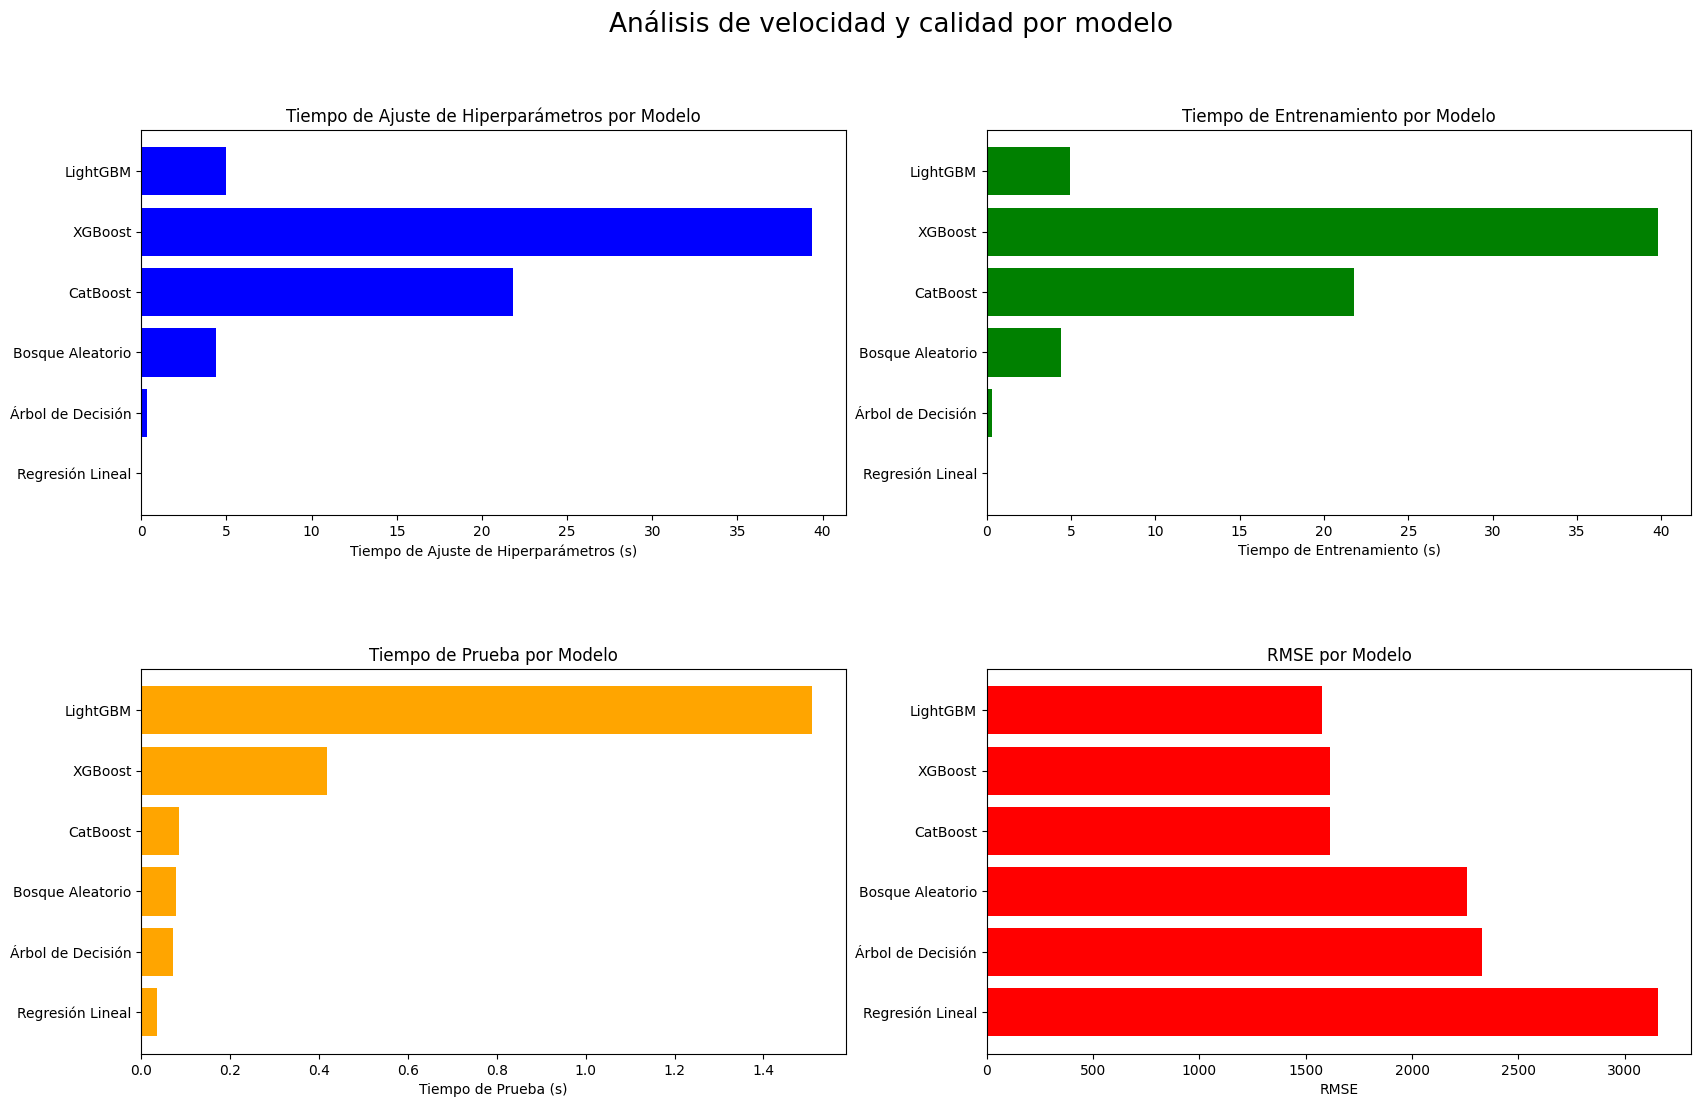

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Análisis de velocidad y calidad por modelo', fontsize=19)
plt.subplots_adjust(hspace=0.4)

#Gráfico 1: Tiempo de ajuste de hiperparámetros
axs[0, 0].barh(models_table['modelo'], models_table['tiempo_ajuste_hiperparámetros'], color='b')
axs[0, 0].set_xlabel('Tiempo de Ajuste de Hiperparámetros (s)')
axs[0, 0].set_title('Tiempo de Ajuste de Hiperparámetros por Modelo')

#Gráfico 2: Tiempo de entrenamiento
axs[0, 1].barh(models_table['modelo'], models_table['tiempo_de_entrenamiento'], color='g')
axs[0, 1].set_xlabel('Tiempo de Entrenamiento (s)')
axs[0, 1].set_title('Tiempo de Entrenamiento por Modelo')

#Gráfico 3: Tiempo de prueba
axs[1, 0].barh(models_table['modelo'], models_table['tiempo_de_prueba'], color='orange')
axs[1, 0].set_xlabel('Tiempo de Prueba (s)')
axs[1, 0].set_title('Tiempo de Prueba por Modelo')

#Gráfico 4: RMSE
axs[1, 1].barh(models_table['modelo'], models_table['RMSE'], color='r')
axs[1, 1].set_xlabel('RMSE')
axs[1, 1].set_title('RMSE por Modelo')

#Mostrar el gráfico
plt.show()

De lo anterior se deduce que, para el tiempo de ajustes de hiperparametros y entrenamiento, el modelo basado en XGBoost requiere más tiempo y, además, los más veloces son Árbol de Decisión y LightGBM.

Respecto a su tiempo de predicción y RMSE, se observa que, Bosque Aleatorio y Catboost son los más veloces, mientras que LightGBM mostró la mejor precisión de todos los modelos examinados, pues el valor de este fue el más bajo. Modelo a usar: LightGBM

En los ajustes de los hiperparametros se pueden observar, para cada uno de los modelos, diferentes de los mismos, seleccionados para ser los que directamente se ajusten para conseguir la mejor calidad en la construcción de nuestro modelo. Se probaron varios valores para la profundidad de arbol, número mínimo de muestras para dividir nodo interno y muestras requeridas para ser nodo final, además de, por supuesto, en otros modelos observarlo con varias combinaciones de número de árboles en bosque aleatorio al igual que con el hiperparametros de la tasa de aprendizaje (learning_rate), la fracción de muestra a utilizar para entrenar cada árbol y el número de hojas máximo por árbol, siempre especificando que la función de pérdida a usar es rmse. Luego se especifíco neg_root_mean_squared_error para evaluar calidad de combinaciones de hiperparametros. cv es el número de pliegues en validación cruzada. Por último, se emplea un diccionario en conjunto con una clave que proporciona el promedio en el conjunto de prueba para cada combinación de hiperparametros y encuentra el puntaje más alto, extrayendo el primer índice de la lista, encuentra el índice donde el puntaje promedio del conjunto de prueba es igual a la puntuación máxima; todo esto manteniendo coherencia con la división del conjunto de datos test_size=0.25

# CONCLUSIÓN

En la primera parte, se tiene la exploración y el preprocesamiento de datos, donde se abordaron todos los detalles pertinentes al dataset antes de proceder a la evaluación y construcción de nuestro modelo de aprendizaje. Se manejaron valores duplicados y ausentes, eliminando aquellos que no pudieron rellenarse una vez creada y aplicada la función correspondiente para tal tarea. Se filtraro y transformaron los datos átipicos teniendo en cuenta el mercado al que va dirigido el modelo y el cliente que nos ha solicitado tal tarea.

Una vez codificadas y escaladas las características, se impementaron diferentes modelos de regresión al igual que distintas formas de potenciación de gradiente para encontrar el mejor, seguido del ajuste de los hiperparámetros ayudados de GridSearchCV que nos permitió obtener las predicciones más optimas dado ciertos ajustes de los mismos, para por fin, una vez evaluados todos, llegar a la conclusión de que el modelo basado en LightGBM  es el más apropiado y optimo en la utilización de nuestro mmodelo de aprendizaje por arrojar los valores más aceptables, superando con creces a la regresión lineal, árbol de decisión y bosque aleatorio. Por lo que, LightGBM ofrece la mejor combinación en lo solicitado por Bargain (velocidad y calidad) para determinar el valor de mercado de un coche de segunda mano.